# Refine Positive genes

Gaol: postive gesn form tpevios stesp are too broad, a methodd to reifne them is needed.

Idea: 
- find cells in the cycicling prcess
    - use geneset scores to find thme
- use rpevius psotive genes set asa progrma and find if these ghenes are expressed ....

In [125]:
# Autorelaod
%load_ext autoreload
%autoreload 2

import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import scanpy as sc
import ast
from matplotlib_venn import venn2
from statsmodels.stats.multitest import multipletests
os.chdir("/home/gdallagl/myworkdir/ESMSec")
print(f"Working directory successfully changed to: {os.getcwd()}")

import utils.my_functions as mf
import utils.dataset_functions as dataf

config_file="/home/gdallagl/myworkdir/ESMSec/config/config.yaml"
config = mf.load_config(config_file)

mf.set_all_seeds(config["random_seed"])

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Working directory successfully changed to: /home/gdallagl/myworkdir/ESMSec
Seeds set successfully to 42 for random, numpy, and PyTorch (if used).


# Load scrna datset

In [2]:
data_dir = config["data_paths"]["neftel_data_folder"]

# Load the matrix (Cell by Gene, or Gene by Cell, default is usually gene x cell)
adata = sc.read_mtx(os.path.join(data_dir, 'Exp_data_UMIcounts.mtx')).T # Transpose to get Cell x Gene

# Read feature names (genes) and barcodes (cells)
genes = pd.read_csv(os.path.join(data_dir, 'Genes.txt'), header=None, names=["gene"], sep='\t')
display(genes.head(2))
cells = pd.read_csv(os.path.join(data_dir, 'Cells.csv'), index_col=0)
display(cells.head(2))

# Assign cell and gene names to the AnnData object
# Note: Ensure the order matches the matrix. The .T above ensures cells are rows and genes are columns.
adata.obs_names = cells.index.astype(str)
adata.var_names = genes.gene.astype(str)

# Read Cell metadata and add to .obs (cell annotations)
cell_meta = pd.read_csv(os.path.join(data_dir, 'Cells.csv'), index_col=0)
adata.obs = cell_meta.loc[adata.obs_names] # Align indices

print("Data Loaded:")
display(adata.obs)
display(adata.obs.columns)

# check data structure
X = adata.X.toarray()
print("Is data raw of log normalised?")
print("min, max", np.min(adata.X), np.max(adata.X))
print(X[X > 0][:20]) 
print("Has gene ecpression been centered?")
gene_means = np.array(X.mean(axis=0)).ravel()
print("Mean expression per gene (first 10):", gene_means[:10])
print("Overall mean of gene means:", gene_means.mean())

gene
0  FAM138A
1    OR4F5

sample  cell_type  complexity    umap1    umap2  g1s_score  \
cell_name                                                              
102_1        102  Malignant        3101  20.8435 -12.0361    -0.0434   
102_2        102  Malignant        2366 -12.6327 -18.9353     1.1051   

           g2m_score cell_cycle_phase  mp_top_score             mp_top  \
cell_name                                                                
102_1         0.1245      Not cycling        1.1889   Oligo Progenitor   
102_2         0.2308             G1/S        1.4424  Cell Cycle - G1/S   

               mp_assignment  
cell_name                     
102_1       Oligo Progenitor  
102_2      Cell Cycle - G1/S

Data Loaded:


sample  cell_type  complexity    umap1    umap2  g1s_score  \
cell_name                                                               
102_1         102  Malignant        3101  20.8435 -12.0361    -0.0434   
102_2         102  Malignant        2366 -12.6327 -18.9353     1.1051   
102_4         102  Malignant        1217 -11.9102 -18.0864    -0.1774   
102_5         102  Malignant        2285  20.1392 -11.5944    -0.1211   
102_7         102  Malignant        1725  17.2946 -16.4965    -0.0337   
...           ...        ...         ...      ...      ...        ...   
105_D2_211    105        NaN         451      NaN      NaN        NaN   
105_D2_212    105  Malignant         506      NaN      NaN        NaN   
105_D2_213    105        NaN         680      NaN      NaN        NaN   
105_D2_214    105  Malignant         622      NaN      NaN        NaN   
105_D2_216    105  Malignant         616      NaN      NaN        NaN   

            g2m_score cell_cycle_phase  mp_top_score             mp_top  \
cell_name                                                                 
102_1          0.1245      Not cycling        1.1889   Oligo Progenitor   
102_2          0.2308             G1/S        1.4424  Cell Cycle - G1/S   
102_4         -0.0561      Not cycling        1.4340             Stress   
102_5         -0.0473      Not cycling        2.6042   Oligo Progenitor   
102_7         -0.0467      Not cycling        1.5445         NPC Glioma   
...               ...              ...           ...                ...   
105_D2_211        NaN              NaN           NaN                NaN   
105_D2_212        NaN              NaN           NaN                NaN   
105_D2_213        NaN              NaN           NaN                NaN   
105_D2_214        NaN              NaN           NaN                NaN   
105_D2_216        NaN              NaN           NaN                NaN   

                mp_assignment  
cell_name                      
102_1        Oligo Progenitor  
102_2       Cell Cycle - G1/S  
102_4                     NaN  
102_5        Oligo Progenitor  
102_7              NPC Glioma  
...                       ...  
105_D2_211                NaN  
105_D2_212                NaN  
105_D2_213                NaN  
105_D2_214                NaN  
105_D2_216                NaN  

[16201 rows x 11 columns]

Index(['sample', 'cell_type', 'complexity', 'umap1', 'umap2', 'g1s_score',
       'g2m_score', 'cell_cycle_phase', 'mp_top_score', 'mp_top',
       'mp_assignment'],
      dtype='object')

Is data raw of log normalised?
min, max 0.0 9814.0
[2. 1. 2. 2. 3. 1. 1. 1. 1. 1. 4. 1. 1. 2. 2. 3. 4. 4. 1. 4.]
Has gene ecpression been centered?
Mean expression per gene (first 10): [0.0000000e+00 0.0000000e+00 2.6541571e-03 6.1724582e-05 0.0000000e+00
 6.1724582e-05 3.3516449e-01 6.9131535e-03 0.0000000e+00 0.0000000e+00]
Overall mean of gene means: 0.30058536


## Simple Preprocessing

- make genes names unique
- remove cell wiht no cell pahse label
- remove cell wiht to low genes, too mamy genes, to high mt score
- remove geens wiht too low cells
- normalise
- log transfoer
- do NOT scale/center !!!

Are genes unique? True


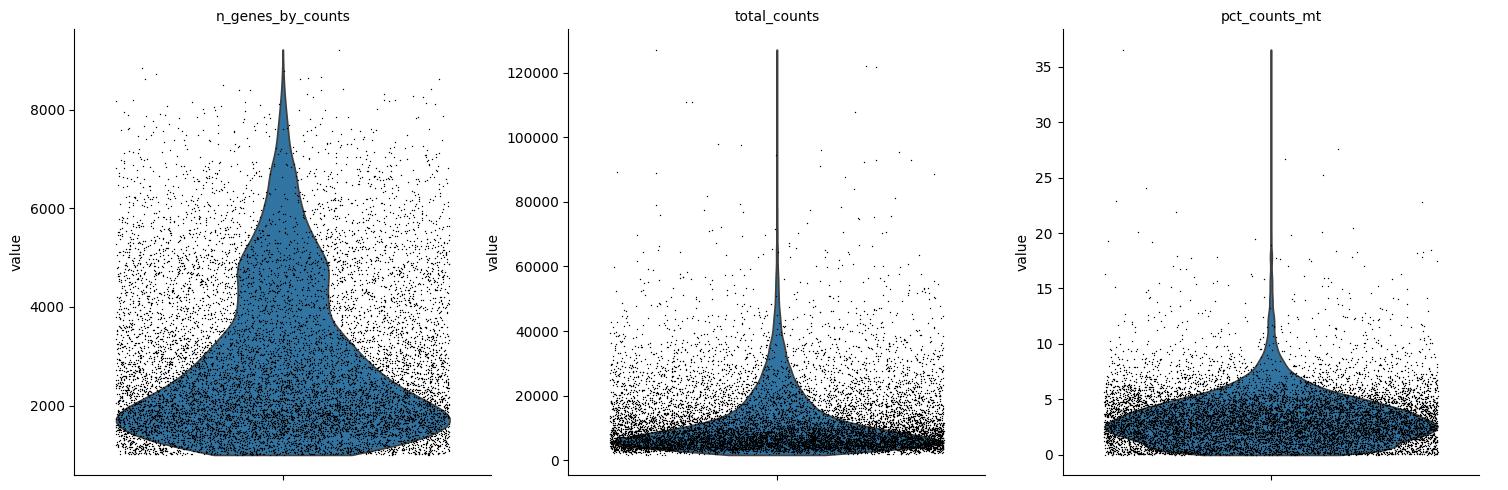

After cell filtering: 10678 cells remain.
After gene filtering: 21831 genes remain.


In [3]:
###############

# ATTENTION: makes genes unqiuie
adata.var_names_make_unique()
print("Are genes unique?", adata.var_names.is_unique)

# ATTETION: remove cells wiht at least 1 None in metadata
adata = adata[~adata.obs[["cell_cycle_phase"]].isna().any(axis=1)].copy()

###############

# Identify mitochondrial genes (human: 'MT-', mouse: 'mt-')
adata.var["mt"] = adata.var_names.str.startswith(("MT-", "mt-"))

# Compute per-cell QC metrics
sc.pp.calculate_qc_metrics(
    adata,
    qc_vars=["mt"],
    percent_top=None,
    log1p=False,
    inplace=True
)

#
sc.pl.violin(adata, ["n_genes_by_counts", "total_counts", "pct_counts_mt"], jitter=0.4, multi_panel=True)

# Filter cells ---
min_genes = 200           # drop low-quality cells
max_genes = 6000          # drop likely doublets
max_mito  = 10            # drop cells with >10% mitochondrial reads

adata = adata[
    (adata.obs["n_genes_by_counts"] > min_genes)
    & (adata.obs["n_genes_by_counts"] < max_genes)
    & (adata.obs["pct_counts_mt"] < max_mito),
].copy()

print(f"After cell filtering: {adata.n_obs} cells remain.")

# Filter genes ---
# Keep genes expressed in at least min_cells cells
min_cells = 3
sc.pp.filter_genes(adata, min_cells=min_cells)
print(f"After gene filtering: {adata.n_vars} genes remain.")

# Normalize per cell (to make library sizes comparable)
sc.pp.normalize_total(adata, target_sum=1e4)

# Log-transform (compress the dynamic range)
sc.pp.log1p(adata)

# Store the normalized data for downstream analysis
adata.raw = adata

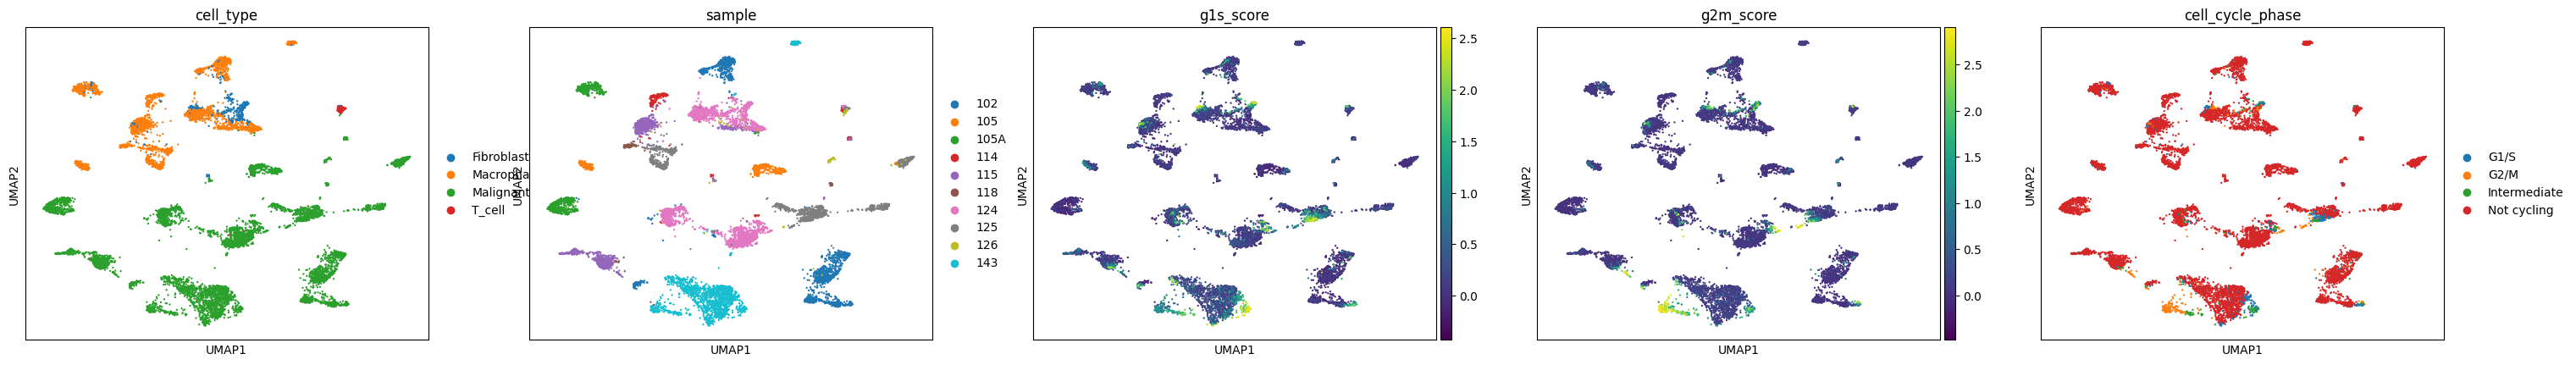

In [4]:
# plot umap
umap_data_array = adata.obs[['umap1', 'umap2']].values
adata.obsm['umap'] = umap_data_array

sc.pl.embedding(adata, basis="umap", color=["cell_type", "sample", "g1s_score", "g2m_score", "cell_cycle_phase"], ncols=5)


# Load precalculated putative positive genes

In [5]:
positive_genes_df = pd.read_csv(config["data_paths"]["broad_positive_genes"])
display(positive_genes_df)

broad_positive_gene_list = positive_genes_df[positive_genes_df.label == "positive"].gene.to_list()
print("positive genes", len(broad_positive_gene_list))

gene  geneset_count  is_guaranteed     label  geneset_percent
0         CDK1             98           True  positive        33.676976
1       FAM64A             98           True  positive        33.676976
2        H2AFZ             98           True  positive        33.676976
3     HIST1H4C             98           True  positive        33.676976
4          HN1             98           True  positive        33.676976
...        ...            ...            ...       ...              ...
7289   ZSCAN20              1          False  ambigous         0.343643
7290   ZSCAN22              1          False  ambigous         0.343643
7291    ZSCAN9              1          False  ambigous         0.343643
7292    ZSWIM4              1          False  ambigous         0.343643
7293      ZUP1              1          False  ambigous         0.343643

[7294 rows x 5 columns]

positive genes 1148


# Verify cell phase precimputed labels

Find which cells are in the cell cycle process:
- adata alredy contains this info
- just to be sure recalcuate, how?
    - take genesets related to cell cycle
    - claulte module

['Not cycling', 'G1/S', 'G2/M', 'Intermediate']
Categories (4, object): ['G1/S', 'G2/M', 'Intermediate', 'Not cycling']

MP1 Cell Cycle - G2/M MP2 Cell Cycle - G1/S MP3 Cell Cylce HMG-rich  \
0                 HMGB2                  PCNA                   STMN1   
1                 UBE2C                  FEN1                  TUBA1B   

  MP4 Chromatin MP5 Cell cycle single-nucleus MP6 Stress 1 MP7 Hypoxia  \
0        GOLGB1                         ATAD2         EGR1       NDRG1   
1         ASH1L                         BRCA1          FOS       BNIP3   

  MP8 Stress (in vitro) MP9 Stress 2 MP10 Proteasomal degradation  ...  \
0                 DDIT3        HSPH1                         CCT5  ...   
1                SLC3A2       HSPA1A                         CCT7  ...   

  MP58 Metal-response MP59 PDAC-related 1 MP60 PDAC-related 2  \
0               DDIT4             CEACAM6               PLAUR   
1                MT1E               S100P                UPP1   

  MP61 PDAC-related 3 MP62 PDAC-related 4 MP63 PDAC-related 5 MP64 Adherens  \
0                GPX2                  CP               NEAT1        DHCR24   
1              ANXA10                MMP7                AGRN          JAG1   

  MP65 Cholesterol Homeostasis MP66 Unassigned 1 MP67 Unassigned 2  
0                         SQLE        AC010343.1             CCNL2  
1                       HMGCS1             AKAP9          CDK5RAP3  

[2 rows x 67 columns]

sample   cell_type  complexity    umap1    umap2  g1s_score  \
cell_name                                                                
102_1         102   Malignant        3101  20.8435 -12.0361    -0.0434   
102_2         102   Malignant        2366 -12.6327 -18.9353     1.1051   
102_4         102   Malignant        1217 -11.9102 -18.0864    -0.1774   
102_7         102   Malignant        1725  17.2946 -16.4965    -0.0337   
102_8         102   Malignant        2252  17.3138 -16.9457     0.0078   
...           ...         ...         ...      ...      ...        ...   
105_D2_139    105   Malignant        1029  28.8941   9.4308    -0.2548   
105_D2_148    105   Malignant        1035  29.0623   9.6065    -0.2660   
105_D2_189    105  Macrophage        1126 -20.2338   8.0329    -0.0252   
105_D2_190    105  Macrophage        1138 -20.1501   8.1597     0.1114   
105_D2_207    105  Macrophage        1137 -20.0538   8.1416    -0.0508   

            g2m_score cell_cycle_phase  mp_top_score             mp_top  \
cell_name                                                                 
102_1          0.1245      Not cycling        1.1889   Oligo Progenitor   
102_2          0.2308             G1/S        1.4424  Cell Cycle - G1/S   
102_4         -0.0561      Not cycling        1.4340             Stress   
102_7         -0.0467      Not cycling        1.5445         NPC Glioma   
102_8         -0.0566      Not cycling        1.0364         NPC Glioma   
...               ...              ...           ...                ...   
105_D2_139    -0.0581      Not cycling        4.9770       Oligo normal   
105_D2_148    -0.0584      Not cycling        5.2820       Oligo normal   
105_D2_189     0.0550      Not cycling        1.0727               MAC3   
105_D2_190     0.0570      Not cycling        1.4108  Monocyte/Secreted   
105_D2_207    -0.0167      Not cycling        1.4494               MAC3   

                mp_assignment  n_genes_by_counts  total_counts  \
cell_name                                                        
102_1        Oligo Progenitor               3113       11446.0   
102_2       Cell Cycle - G1/S               2374        6273.0   
102_4                     NaN               1220        2867.0   
102_7              NPC Glioma               1732        4911.0   
102_8              NPC Glioma               2263        6541.0   
...                       ...                ...           ...   
105_D2_139                NaN               1045        7953.0   
105_D2_148                NaN               1047        8796.0   
105_D2_189               MAC3               1136       13710.0   
105_D2_190                NaN               1152       26001.0   
105_D2_207               MAC3               1149       14057.0   

            total_counts_mt  pct_counts_mt  G2_M_score  G1_S_score  cc_score  
cell_name                                                                     
102_1                 872.0       7.618382   -0.119369   -0.235912 -0.136094  
102_2                 165.0       2.630320    0.175133    0.325424  0.213183  
102_4                  64.0       2.232299   -0.012209   -0.124320 -0.015065  
102_7                 292.0       5.945836   -0.052760   -0.152413 -0.057671  
102_8                 193.0       2.950619   -0.056767   -0.157831 -0.064305  
...                     ...            ...         ...         ...       ...  
105_D2_139            103.0       1.295109   -0.043099   -0.230465 -0.075781  
105_D2_148            221.0       2.512506   -0.112314   -0.168034 -0.081283  
105_D2_189            199.0       1.451495   -0.051310   -0.186852 -0.039900  
105_D2_190            598.0       2.299911   -0.045874   -0.155893 -0.027447  
105_D2_207            313.0       2.226649   -0.081042   -0.187761 -0.083555  

[10678 rows x 18 columns]

cc_score  G1_S_score  G2_M_score  g1s_score  g2m_score
cc_score    1.000000    0.816733    0.937514   0.740424   0.847158
G1_S_score  0.816733    1.000000    0.675787   0.863205   0.537290
G2_M_score  0.937514    0.675787    1.000000   0.576193   0.903954
g1s_score   0.740424    0.863205    0.576193   1.000000   0.582209
g2m_score   0.847158    0.537290    0.903954   0.582209   1.000000

<Axes: ylabel='Frequency'>

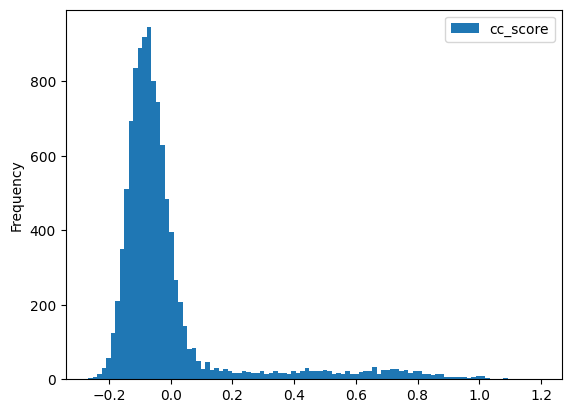

In [6]:
# sho what cell cyel ingo is alredy present
display(adata.obs.cell_cycle_phase.unique())

# read VERY spefiic gene set for ccylcing cells
metaprograms_df = pd.read_excel(config["data_paths"]["metaprograms_3CA"])
display(metaprograms_df.head(2))

strict_G2_M_genes = set(metaprograms_df["MP1 Cell Cycle - G2/M"])
strict_G1_S_genes = set(metaprograms_df["MP2 Cell Cycle - G1/S"])
strict_cc_genes = strict_G2_M_genes.union(strict_G1_S_genes)
len(strict_cc_genes)

# calculate module for each cell
ctrl_size=10
sc.tl.score_genes(
    adata=adata, 
    gene_list=list(strict_G2_M_genes),
    ctrl_size=ctrl_size, #ATTENTION: not default
    gene_pool=None, #all genes
    n_bins=25,
    use_raw=False, #use lognorm
    score_name="G2_M_score"
)
sc.tl.score_genes(
    adata=adata, 
    gene_list=list(strict_G1_S_genes),
    ctrl_size=ctrl_size, #ATTENTION: not default
    gene_pool=None, #all genes
    n_bins=25,
    use_raw=False, #use lognorm
    score_name="G1_S_score"
)
sc.tl.score_genes(
    adata=adata, 
    gene_list=list(strict_cc_genes),
    ctrl_size=ctrl_size, #ATTENTION: not default
    gene_pool=None, #all genes
    n_bins=25,
    use_raw=False, #use lognorm
    score_name="cc_score"
)

display(adata.obs)

# chekc if new scores correlate wiht old ones
display(adata.obs[["cc_score", "G1_S_score", "G2_M_score", "g1s_score", "g2m_score"]].corr())
adata.obs[["cc_score"]].plot(kind="hist", bins=100)

# Select only cycling cells

Use precomputed labels:
- only cycling
- only malignant
    - why? dont want to have cell type influence the analysis

In [57]:
# adata of 
    # only cycling cells
    # only malignanet
adata_cc = adata[
    (adata.obs["cell_cycle_phase"] != "Not cycling") &
    (adata.obs["cell_type"] == "Malignant") #like in apper https://www.weizmann.ac.il/sites/3CA/study-data/cell-cycle/20099
    ].copy()

# ATTNETION: Remove genes with zero/low variance
gene_variances = np.var(adata_cc.X.toarray(), axis=0)
adata_cc = adata_cc[:, gene_variances > 1e-6].copy()

# Select postive genes in adata
print("Broad postive genes:", len(broad_positive_gene_list))
broad_positive_gene_list_in_adata = [g for g in broad_positive_gene_list if g in adata_cc.var_names]

broad_positive_gene_missing = set(broad_positive_gene_list).difference(broad_positive_gene_list_in_adata)
print("Broad postive genes in adata:", len(broad_positive_gene_list_in_adata))
print("Missing genes:", len(broad_positive_gene_missing), broad_positive_gene_missing)

Broad postive genes: 1148
Broad postive genes in adata: 1014
Missing genes: 134 {'CCNQ', 'CEP295', 'H4C6', 'EDN3', 'MIR208A', 'CASP8AP2', 'INTS13', 'KMT5A', 'OVOL1', 'TUBB3', 'OR2A4', 'MIR424', 'USP50', 'MIR26A1', 'MIR519D', 'MACROH2A1', 'INS', 'PIMREG', 'MIR503', 'RFPL1', 'MIR29C', 'GPR15LG', 'MIR133A1', 'H4C11', 'NANOGP8', 'CENPS', 'MIR221', 'DMRT1', 'TUBB8', 'TP63', 'MIR372', 'NSD2', 'SEM1', 'MIR137', 'H2BC4', 'MRNIP', 'MIR451A', 'MOS', 'SGO2', 'CEP131', 'CD28', 'MIR222', 'H4C1', 'PRAP1', 'MIR873', 'H4C2', 'BABAM2', 'MISP', 'HORMAD1', 'HASPIN', 'SLF1', 'PHOX2B', 'H2AX', 'MIR21', 'H2BC11', 'CIP2A', 'H4C5', 'H4C12', 'EPGN', 'H4C14', 'H2BC7', 'PRP4K', 'TUBAL3', 'MIR362', 'ABRAXAS1', 'DRD3', 'NOP53', 'MIR16-1', 'TM4SF5', 'MIR520H', 'ABRAXAS2', 'UBD', 'CDC14C', 'RIPOR2', 'MIR10A', 'SFN', 'MEIOC', 'MIR15A', 'H2BC13', 'MIR30C2', 'H2BC21', 'CEP43', 'PABIR1', 'H2BC15', 'MIR193A', 'TUBA3C', 'PCLAF', 'H2BC3', 'H4C8', 'DUX4', 'TENT4A', 'FIRRM', 'SGO1', 'H3C2', 'PKHD1', 'KNL1', 'MAP3K20', 'H2AZ2

### Oder cells by CC scores

In [58]:
# Sort adata by "cc_score"strict_cc_genes
    # G2/M by g2m_score
    # G1/S by g1s_score 
    # Intermediate by mean_g1_g2_scores

# claculte mean for intermediate
adata_cc.obs["mean_g1_g2_scores"] = adata_cc.obs[["g1s_score", "g2m_score"]].mean(axis=1)

# Define your sorting rule
def sort_key(row):
    if row["cell_cycle_phase"] == "G2/M":
        return row["g2m_score"]
    elif row["cell_cycle_phase"] == "G1/S":
        return row["g1s_score"]
    # Intermediate
    elif row["cell_cycle_phase"] == "Intermediate":
        return row["mean_g1_g2_scores"]

# Apply the rule to create a sorting column
adata_cc.obs["sort_value"] = adata_cc.obs.apply(sort_key, axis=1)

adata_cc.obs

sample  cell_type  complexity    umap1    umap2  g1s_score  \
cell_name                                                               
102_2         102  Malignant        2366 -12.6327 -18.9353     1.1051   
102_16        102  Malignant        3587  21.0868 -12.5472     1.8253   
102_42        102  Malignant        1853  19.6080 -11.1338     0.7286   
102_53        102  Malignant        3340  16.3413 -16.0424     2.1944   
102_105       102  Malignant        2996  21.7673 -23.4979     1.7695   
...           ...        ...         ...      ...      ...        ...   
105_C1_519    105  Malignant        2088  10.4338   8.0263     0.4886   
105_C1_596    105  Malignant        1946  10.7391   7.8324     0.9896   
105_C2_75     105  Malignant        1257  10.0922   7.1147    -0.0450   
105_C2_136    105  Malignant        2029  10.1349   7.3584     1.2862   
105_C2_582    105  Malignant        1193  10.3498   7.0529     0.8167   

            g2m_score cell_cycle_phase  mp_top_score             mp_top  \
cell_name                                                                 
102_2          0.2308             G1/S        1.4424  Cell Cycle - G1/S   
102_16         0.4834             G1/S        2.5533  Cell Cycle - G1/S   
102_42         0.0473             G1/S        1.5388        Respiration   
102_53         0.6261             G1/S        2.9818  Cell Cycle - G1/S   
102_105        1.1213             G1/S        2.7594  Cell Cycle - G1/S   
...               ...              ...           ...                ...   
105_C1_519     0.7821             G2/M        2.8255  Cell Cycle - G2/M   
105_C1_596     0.0019             G1/S        1.5301  Cell Cycle - G1/S   
105_C2_75      0.9044             G2/M        3.3855  Cell Cycle - G2/M   
105_C2_136     0.1155             G1/S        1.9264  Cell Cycle - G1/S   
105_C2_582    -0.0509             G1/S        1.6966  Cell Cycle - G1/S   

                mp_assignment  n_genes_by_counts  total_counts  \
cell_name                                                        
102_2       Cell Cycle - G1/S               2374        6273.0   
102_16      Cell Cycle - G1/S               3601       17712.0   
102_42                    NaN               1863        5418.0   
102_53      Cell Cycle - G1/S               3354       11560.0   
102_105     Cell Cycle - G1/S               3007       10307.0   
...                       ...                ...           ...   
105_C1_519                NaN               2108       11717.0   
105_C1_596                NaN               1970       11648.0   
105_C2_75                 NaN               1273        6120.0   
105_C2_136                NaN               2053       11990.0   
105_C2_582                NaN               1207        5155.0   

            total_counts_mt  pct_counts_mt  G2_M_score  G1_S_score  cc_score  \
cell_name                                                                      
102_2                 165.0       2.630320    0.175133    0.325424  0.213183   
102_16                986.0       5.566847    0.483979    0.554712  0.507409   
102_42                384.0       7.087486    0.241827    0.318235  0.230682   
102_53                444.0       3.840831    0.506276    0.763581  0.585375   
102_105               445.0       4.317454    0.838029    0.713333  0.757374   
...                     ...            ...         ...         ...       ...   
105_C1_519            611.0       5.214645    0.966568    0.182949  0.556169   
105_C1_596            532.0       4.567307    0.176050    0.285820  0.274572   
105_C2_75             257.0       4.199347    1.227763    0.012145  0.662628   
105_C2_136            542.0       4.520434    0.317426    0.425523  0.406452   
105_C2_582            227.0       4.403491    0.155323    0.472528  0.352026   

            mean_g1_g2_scores  sort_value  
cell_name                                  
102_2                 0.66795      1.1051  
102_16                1.15435      1.8253  
102_42   

In [59]:
# create df cell x gene with expression values inside
    # ATTENTION: filter only overlalping genes
df = pd.DataFrame(adata_cc[:, broad_positive_gene_list_in_adata].X.toarray(), 
                  index=adata_cc.obs_names, 
                  columns=broad_positive_gene_list_in_adata)

# Sort cells by phase with proper ordering
df_sorted = df.copy()
df_sorted["cell_cycle_phase"] = adata_cc.obs["cell_cycle_phase"]
df_sorted["sort_value"] = adata_cc.obs["sort_value"]

# Define phase order for sorting
phase_order = ['G1/S', 'Intermediate', 'G2/M'] 

# Convert to categorical with explicit order
df_sorted["cell_cycle_phase"] = pd.Categorical(df_sorted["cell_cycle_phase"], categories=phase_order, ordered=True)

# sort cell
    #before by cell phase
    # then by speific module
df_sorted = df_sorted.sort_values(["cell_cycle_phase", "sort_value"])

# save for later
phases_sorted = df_sorted["cell_cycle_phase"]

# remove non numerical cols
df_sorted = df_sorted.drop(columns="cell_cycle_phase")
df_sorted = df_sorted.drop(columns="sort_value")

display(df_sorted)

CDK1    FAM64A     H2AFZ  HIST1H4C       HN1  KIAA0101  \
cell_name                                                                 
115_2_190    0.000000  0.000000  2.377176  0.755098  1.180389  0.000000   
143_7d_1610  0.000000  0.000000  1.446006  2.244947  2.768339  0.000000   
143_7d_1693  0.000000  0.000000  1.813131  0.996900  0.996900  0.294142   
115_2_759    0.000000  0.000000  3.212085  1.939849  2.558420  1.380993   
143_7d_1236  0.000000  0.000000  1.187165  1.347350  2.255667  0.000000   
...               ...       ...       ...       ...       ...       ...   
125_2_753    1.488671  1.855030  3.159037  2.899002  3.001551  0.398892   
143_7d_302   2.190269  1.887528  3.750816  4.581412  3.230005  1.735046   
115_2_133    2.297243  1.235476  2.516627  0.595170  1.447708  0.000000   
143_7d_1888  1.093281  2.460773  2.957680  0.000000  3.110298  0.334191   
115_1_133    2.935812  1.938108  2.853615  0.910836  2.007014  0.402438   

                CCNB1      PLK1     BIRC5       RB1  ...   SUV39H1      TAF2  \
cell_name                                            ...                       
115_2_190    0.560689  0.000000  0.319137  0.000000  ...  0.000000  0.560689   
143_7d_1610  0.000000  0.000000  0.000000  0.500305  ...  0.000000  0.000000   
143_7d_1693  0.000000  0.000000  0.000000  0.000000  ...  0.000000  0.000000   
115_2_759    0.000000  0.000000  1.380993  0.000000  ...  0.000000  0.000000   
143_7d_1236  0.000000  0.000000  0.000000  0.450721  ...  0.000000  0.000000   
...               ...       ...       ...       ...  ...       ...       ...   
125_2_753    2.284736  2.062093  2.871633  0.000000  ...  0.000000  0.683271   
143_7d_302   1.335399  0.875784  1.555056  0.000000  ...  0.000000  0.000000   
115_2_133    2.211937  2.375842  1.447708  0.000000  ...  1.235476  0.000000   
143_7d_1888  1.603037  1.880279  2.460773  0.000000  ...  0.000000  0.334191   
115_1_133    2.794806  2.243146  2.132034  0.000000  ...  0.000000  0.000000   

             TBCE  TPD52L1     TUBD1      UBR7     USP19    YTHDC2    ZNF324  \
cell_name                                                                      
115_2_190     0.0      0.0  0.000000  0.319137  0.560689  0.000000  0.319137   
143_7d_1610   0.0      0.0  0.500305  0.000000  0.000000  0.000000  0.000000   
143_7d_1693   0.0      0.0  0.000000  0.294142  0.000000  0.000000  0.294142   
115_2_759     0.0      0.0  0.000000  0.000000  0.000000  0.000000  0.000000   
143_7d_1236   0.0      0.0  0.000000  0.450721  0.000000  0.000000  0.000000   
...           ...      ...       ...       ...       ...       ...       ...   
125_2_753     0.0      0.0  0.000000  0.000000  0.000000  0.000000  0.000000   
143_7d_302    0.0      0.0  0.875784  0.659506  0.000000  0.383164  0.000000   
115_2_133     0.0      0.0  0.000000  0.000000  0.000000  0.595170  0.000000   
143_7d_1888   0.0      0.0  0.334191  0.334191  0.000000  0.334191  0.000000   
115_1_133     0.0      0.0  0.402438  0.688603  0.000000  0.000000  0.000000   

               ZNHIT1  
cell_name              
115_2_190    0.917793  
143_7d_1610  1.446006  
143_7d_1693  0.706025  
115_2_759    1.380993  
143_7d_1236  0.996333  
...               ...  
125_2_753    0.904427  
143_7d_302   1.053502  
115_2_133    0.965720  
143_7d_1888  0.584236  
115_1_133    0.910836  

[877 rows x 1014 columns]

### Visual Inspection: gene pattern based on phase

Idea: Cluster genes and see if they cluster to speific cell phases.

Unique phases: ['G1/S', 'Intermediate', 'G2/M']
Categories (3, object): ['G1/S' < 'Intermediate' < 'G2/M']
Phase counts: cell_cycle_phase
G1/S            446
G2/M            285
Intermediate    146
Name: count, dtype: int64


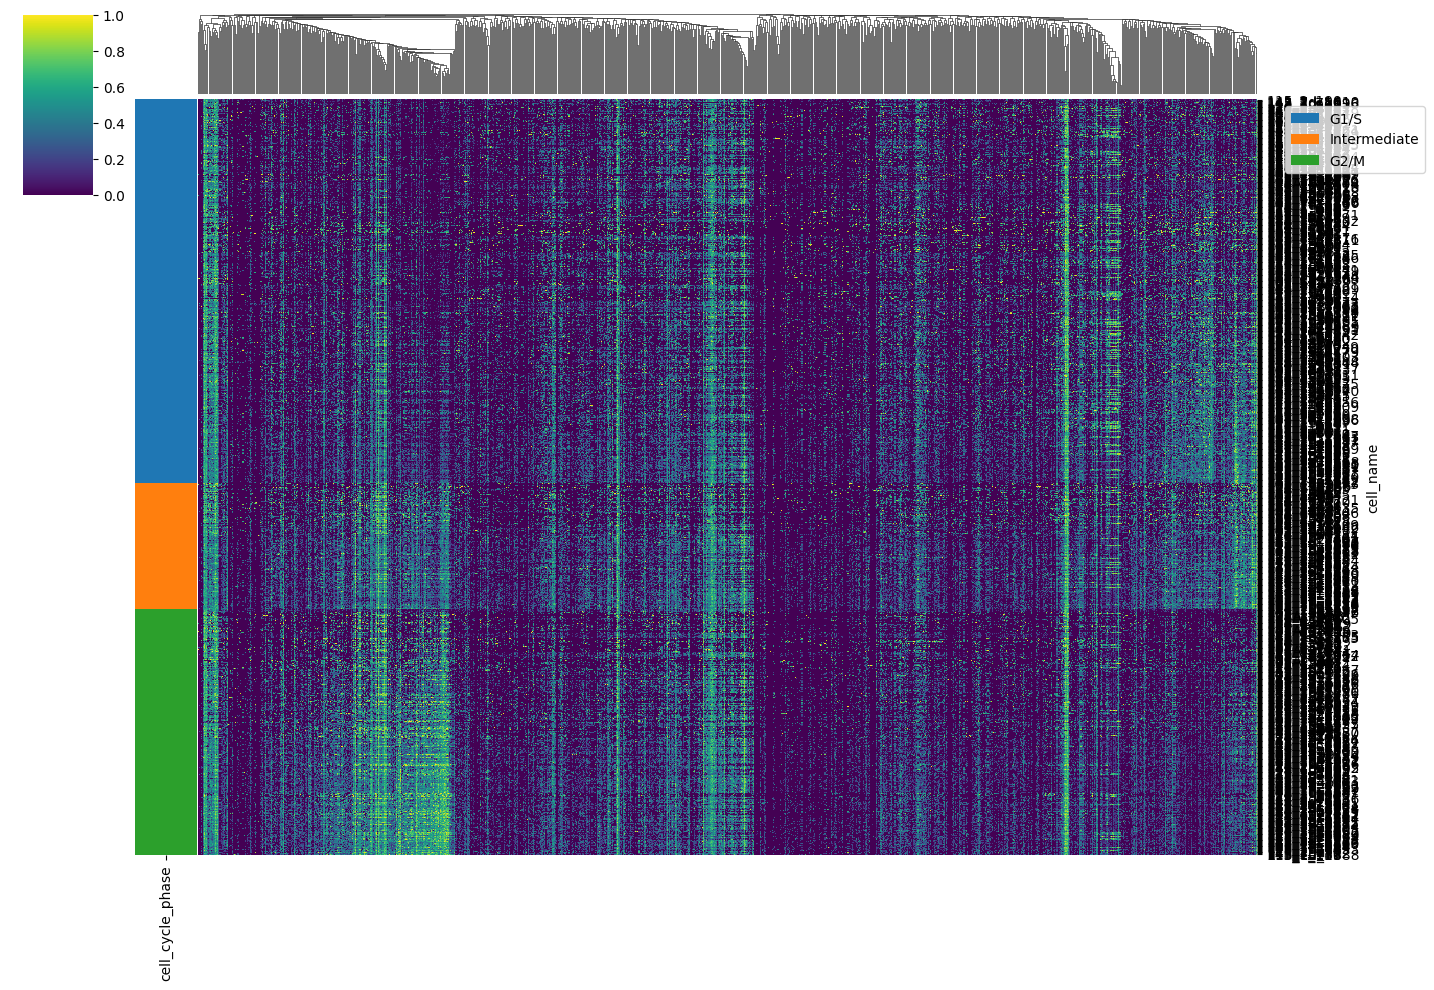

In [60]:
# Create mapping: cell-phase --> color

# Check what phases you actually have
print("Unique phases:", phases_sorted.unique())
print("Phase counts:", phases_sorted.value_counts())

# Create color mapping - make sure these match your actual phase names
phase_color_map = {
    'G1/S': '#1f77b4',
    'Intermediate': '#ff7f0e', 
    'G2/M': '#2ca02c',
}

phase_colors = phases_sorted.map(phase_color_map)


#########


# Create the clustermap
g = sns.clustermap(
    df_sorted,  # cells are row
    figsize=(14, 10),
    cmap="viridis",

    col_cluster=True, #wnat to cluster genes
    row_cluster=False,

    method="average", # method to do clustering
    metric="correlation", # metric to aggregate in hierarhcical clustering

    row_colors=phase_colors,
    xticklabels=False,
    yticklabels=True,
    colors_ratio=0.05,  
    dendrogram_ratio=0.1,

    standard_scale=1, #for each row(0) or column, subtract the minimum and divide each by its maximum.

)

# Add legend
from matplotlib.patches import Patch
legend_elements = [Patch(facecolor=color, label=phase) 
                   for phase, color in phase_color_map.items()]
g.ax_heatmap.legend(handles=legend_elements, loc='upper left', 
                    bbox_to_anchor=(1.02, 1), frameon=True)

# 1. By Std

Rationale: a gene is cycling in CC if std across cell phases is high

Phase means shape: (3, 1014)
Phases: ['G1/S', 'G2/M', 'Intermediate']
Gene std shape: (1014,)
Number of variable genes: 760


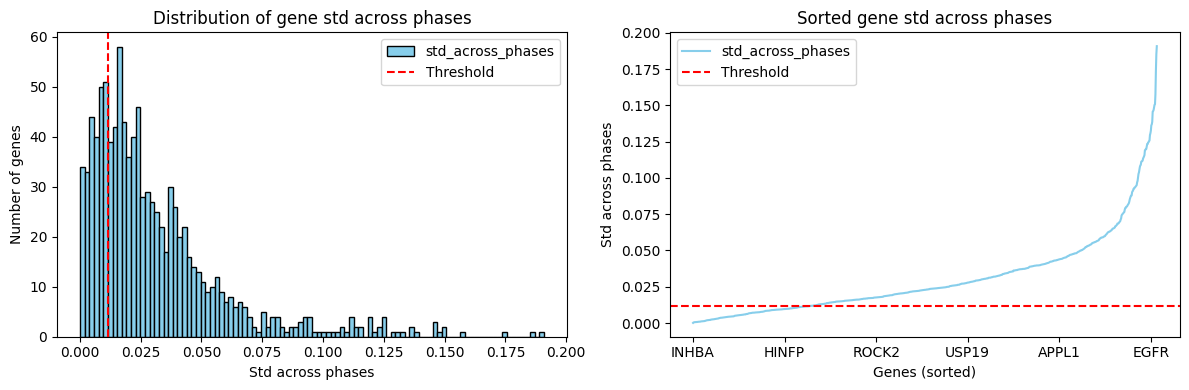

In [85]:
# Add phase information
df_sorted["cell_cycle_phase"] = adata_cc.obs["cell_cycle_phase"].values

# Compute average expression per phase
phase_means = df_sorted.groupby("cell_cycle_phase", observed=False).mean() # Calculate the mean of ALL OTHER NUMERIC COLUMNS
print("Phase means shape:", phase_means.shape)  # Should be (3 phases, n_genes)
print("Phases:", phase_means.index.tolist())

# clauclte std acorss the precimputed means
phase_means.loc["std_across_phases"] = phase_means.std(axis=0)
print("Gene std shape:", phase_means.loc["std_across_phases"].shape)  # (n_genes,)

# Select genes with enough variance
threshold = phase_means.loc["std_across_phases"].quantile(0.25)  # e.g., 2nd percentile

# Genes with high or low variance
variable_genes = phase_means.columns[phase_means.loc["std_across_phases"] > threshold]
constant_genes = phase_means.columns[phase_means.loc["std_across_phases"] <= threshold]

print("Number of variable genes:", len(variable_genes))

plt.figure(figsize=(12, 4))

# Histogram
plt.subplot(1, 2, 1)
phase_means.loc["std_across_phases"].plot(kind="hist", bins=100, color='skyblue', edgecolor='black')
plt.axvline(threshold, color='red', linestyle='--', label='Threshold')
plt.title("Distribution of gene std across phases")
plt.xlabel("Std across phases")
plt.ylabel("Number of genes")
plt.legend()

# Sorted values
plt.subplot(1, 2, 2)
phase_means.loc["std_across_phases"].sort_values().plot(color='skyblue')
plt.axhline(threshold, color='red', linestyle='--', label='Threshold')
plt.title("Sorted gene std across phases")
plt.xlabel("Genes (sorted)")
plt.ylabel("Std across phases")
plt.legend()

plt.tight_layout()
plt.show()

Text(0.5, 1.05, 'Clustermap of variable genes')

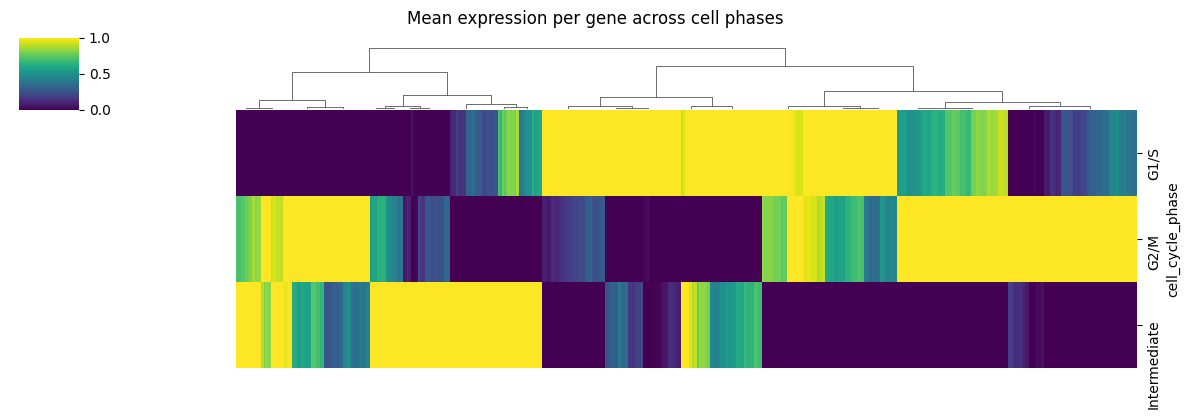

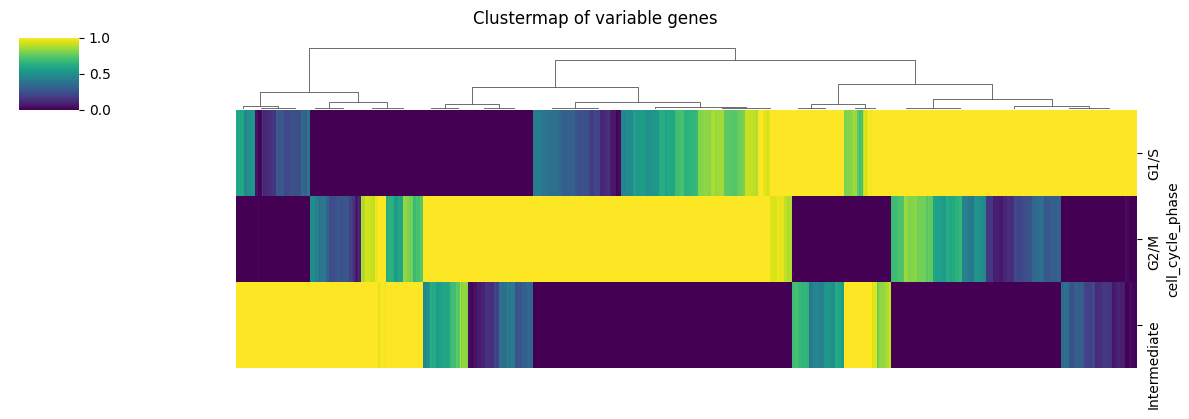

In [95]:
# Full phase_means clustermap
sns.clustermap(
    phase_means.iloc[:-1, :],  # exclude std row if needed
    figsize=(12, 4),
    cmap="viridis",
    col_cluster=True,  # cluster genes
    row_cluster=False, # do not cluster phases
    method="average",
    metric="correlation",
    xticklabels=False,
    yticklabels=True,
    standard_scale=1,
)
plt.suptitle("Mean expression per gene across cell phases", y=1.05)

# Variable genes only
sns.clustermap(
    phase_means.iloc[:-1, :][variable_genes],  # exclude std row if needed
    figsize=(12, 4),
    cmap="viridis",
    col_cluster=True,  # cluster genes
    row_cluster=False, # do not cluster phases
    method="average",
    metric="correlation",
    xticklabels=False,
    yticklabels=True,
    standard_scale=1,
)
plt.suptitle("Clustermap of variable genes", y=1.05)


In [96]:
# add results to df
positive_genes_df["p_by_std"] = [g in variable_genes for g in positive_genes_df.gene.to_list()]

# By Kruskal test


In [97]:
# import numpy as np
# from scipy.stats import kruskal
# from statsmodels.stats.multitest import multipletests

# # Test each gene for differential expression across phases
# results = []

# for gene in broad_positive_gene_list_in_adata:
#     # Get expression values per phase
#     expr_by_phase = {} #A dictionary with N(one per phase) lists (each elemnt is a cell) of expression values 
#     for phase in adata_cc.obs['cell_cycle_phase'].unique():
#         cells = adata_cc.obs['cell_cycle_phase'] == phase #extract all cells in that phase
#         expr_by_phase[phase] = adata_cc[cells, gene].X.toarray().flatten() #Get expression values for the gene across those cells
    
#     # Check if gene has any variance at all
#     all_values = np.concatenate(list(expr_by_phase.values()))
#     if np.std(all_values) < 1e-10:  # Skip genes with no variance
#         continue
    
#     # Check if there's variance within at least 2 groups
#     variances = [np.std(v) for v in expr_by_phase.values()]
#     if sum(v > 1e-10 for v in variances) < 2:  # Need variance in at least 2 phases
#         continue
    
#     try:
#         # Kruskal-Wallis test (non-parametric ANOVA) 
#         # Treats each cell independently (ignores biological replicates) --> WRING !!!
#         stat, pval = kruskal(*expr_by_phase.values())
        
#         # Calculate effect size (variance across phase means)
#         #p-value tells you IF there's a difference
#         #Effect size tells you HOW BIG the difference is
#         phase_means = [np.mean(v) for v in expr_by_phase.values()]
#         effect_size = np.std(phase_means)
        
#         results.append({
#             'gene': gene,
#             'pvalue': pval,
#             'effect_size': effect_size,
#             'mean_expr': np.mean(all_values)
#         })
#     except ValueError:
#         # Skip genes that still cause issues
#         continue

# results_df = pd.DataFrame(results)

# # multi teset conrrection
# results_df['pvalue_adj'] = multipletests(results_df['pvalue'], method='fdr_bh')[1]

# # Keep genes with significant variation AND large effect
# cc_genes = results_df[
#     (results_df['pvalue_adj'] < 0.05) & 
#     (results_df['effect_size'] > results_df['effect_size'].quantile(0.2))  
# ]['gene'].tolist()

# print(f"Found {len(cc_genes)} cell cycle genes")
# display(results_df.sort_values('effect_size', ascending=False))

# sorted(cc_genes)

# positive_genes_df["p_by_kruskal"] = [g in cc_genes for g in positive_genes_df.gene.to_list()]


# By Wilcoxon Test

Not optimal test for scrna (nned pseudobulk and desseq2 or Limma or EdgeR)

In [100]:
# Test all genes at once
sc.tl.rank_genes_groups( # ATTENTION; needs log norm data
    adata_cc, 
    groupby='cell_cycle_phase',
    method='wilcoxon',  # one-vs-rest comparisons
                        # so a gene will be tested n choose k times (in or case 3)
    key_added='phase_de',
    use_raw=False
)

print(adata_cc.uns["phase_de"])

# Extract results --> covert to df
# 1. Significant in at least one phase
# 2. Have large fold change
results = sc.get.rank_genes_groups_df(adata_cc, group=None, key='phase_de')

# Filter
wilcoxon_positive_genes_df = results[
    results['names'].isin(broad_positive_gene_list_in_adata) &
    (results['pvals_adj'] <= 0.05) &
    (results['logfoldchanges'].abs() >= 0.2)
]

display(wilcoxon_positive_genes_df)

{'params': {'groupby': 'cell_cycle_phase', 'reference': 'rest', 'method': 'wilcoxon', 'use_raw': False, 'layer': None, 'corr_method': 'benjamini-hochberg'}, 'names': rec.array([('GINS2', 'PTTG1', 'HIST1H4C'), ('MCM5', 'CDC20', 'ESCO2'),
           ('MCM3', 'CCNB1', 'RRM2'), ..., ('CENPF', 'MCM7', 'S100B'),
           ('BIRC5', 'GINS2', 'C1orf61'), ('PTTG1', 'PCNA', 'EEF1A1')],
          dtype=[('G1/S', 'O'), ('G2/M', 'O'), ('Intermediate', 'O')]), 'scores': rec.array([( 15.677265,  21.515015, 12.017877 ),
           ( 14.989848,  20.629004, 10.696493 ),
           ( 14.165375,  20.258718, 10.692378 ), ...,
           (-21.591904, -15.665862, -5.8960347),
           (-21.817354, -16.489542, -6.131504 ),
           (-22.84768 , -17.405153, -6.5618258)],
          dtype=[('G1/S', '<f4'), ('G2/M', '<f4'), ('Intermediate', '<f4')]), 'pvals': rec.array([(2.16371113e-055, 1.12641805e-102, 2.86232820e-33),
           (8.55482441e-051, 1.50721551e-094, 1.05702927e-26),
           (1.50064233e-0

group   names     scores  logfoldchanges         pvals  \
0              G1/S   GINS2  15.677265        2.236144  2.163711e-55   
1              G1/S    MCM5  14.989848        2.684346  8.554824e-51   
2              G1/S    MCM3  14.165375        2.058793  1.500642e-45   
3              G1/S    PCNA  12.794274        1.390431  1.764941e-37   
4              G1/S    MCM7  12.097391        1.597906  1.090211e-33   
...             ...     ...        ...             ...           ...   
38892  Intermediate  DYNLL2   3.248795        0.574605  1.158949e-03   
38901  Intermediate  ARID1A   3.218020        0.531101  1.290790e-03   
38904  Intermediate   CENPP   3.209073        0.800137  1.331635e-03   
38905  Intermediate   TFDP1   3.207642        0.514562  1.338280e-03   
57672  Intermediate  RPS27A  -3.890073       -0.225869  1.002140e-04   

          pvals_adj  
0      1.156143e-52  
1      4.013673e-48  
2      5.154706e-43  
3      4.297521e-35  
4      2.356325e-31  
...             ...  
38892  4.440943e-02  
38901  4.821287e-02  
38904  4.945046e-02  
38905  4.960147e-02  
57672  6.299727e-03  

[860 rows x 6 columns]

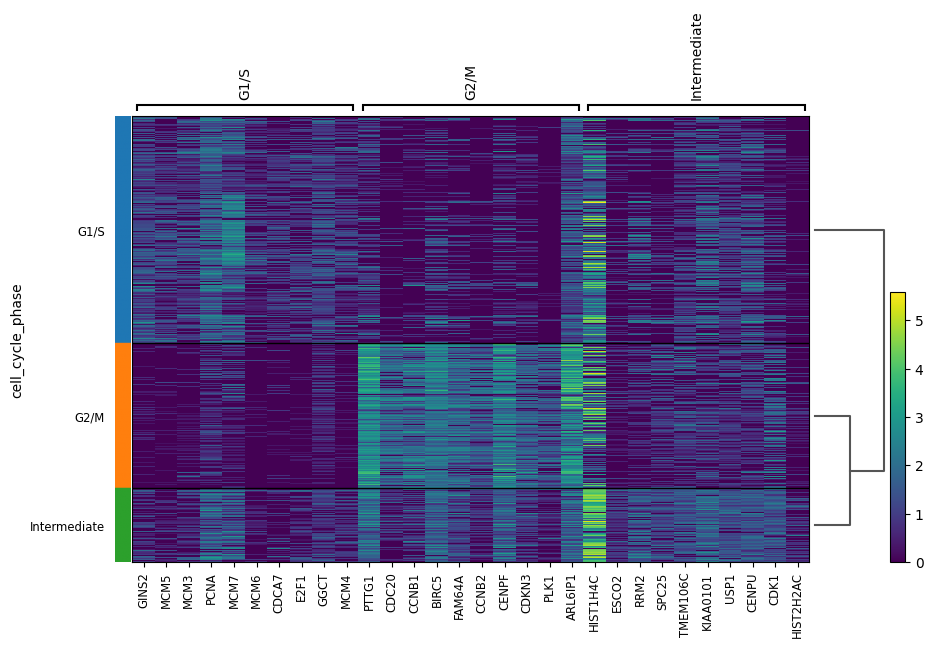

In [101]:
sc.pl.rank_genes_groups_heatmap(
    adata_cc,
    #groups=,
    key="phase_de",
    n_genes=10, # negative fro downregulated genes
    show_gene_labels=True
)
# Cols are the top genes for each group (e.g., the top 10 markers for Cluster 1, followed by the top 10 for Cluster 2, etc.)
# Row aew cells of that group
#Color Intensity typically represents the ean expression (or Z-score) of the gene

In [102]:
# add
positive_genes_df["p_by_wilcoxon"] = [g in wilcoxon_positive_genes_df.names.to_list() for g in positive_genes_df.gene.to_list()]


Unique phases: ['G1/S', 'Intermediate', 'G2/M']
Categories (3, object): ['G1/S' < 'Intermediate' < 'G2/M']
Phase counts: cell_cycle_phase
G1/S            446
G2/M            285
Intermediate    146
Name: count, dtype: int64
G1/S
G2/M
Intermediate


/tmp/ipykernel_12072/1791245734.py:22: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for i, g in wilcoxon_positive_genes_df.sort_values(by="scores").groupby("group"):


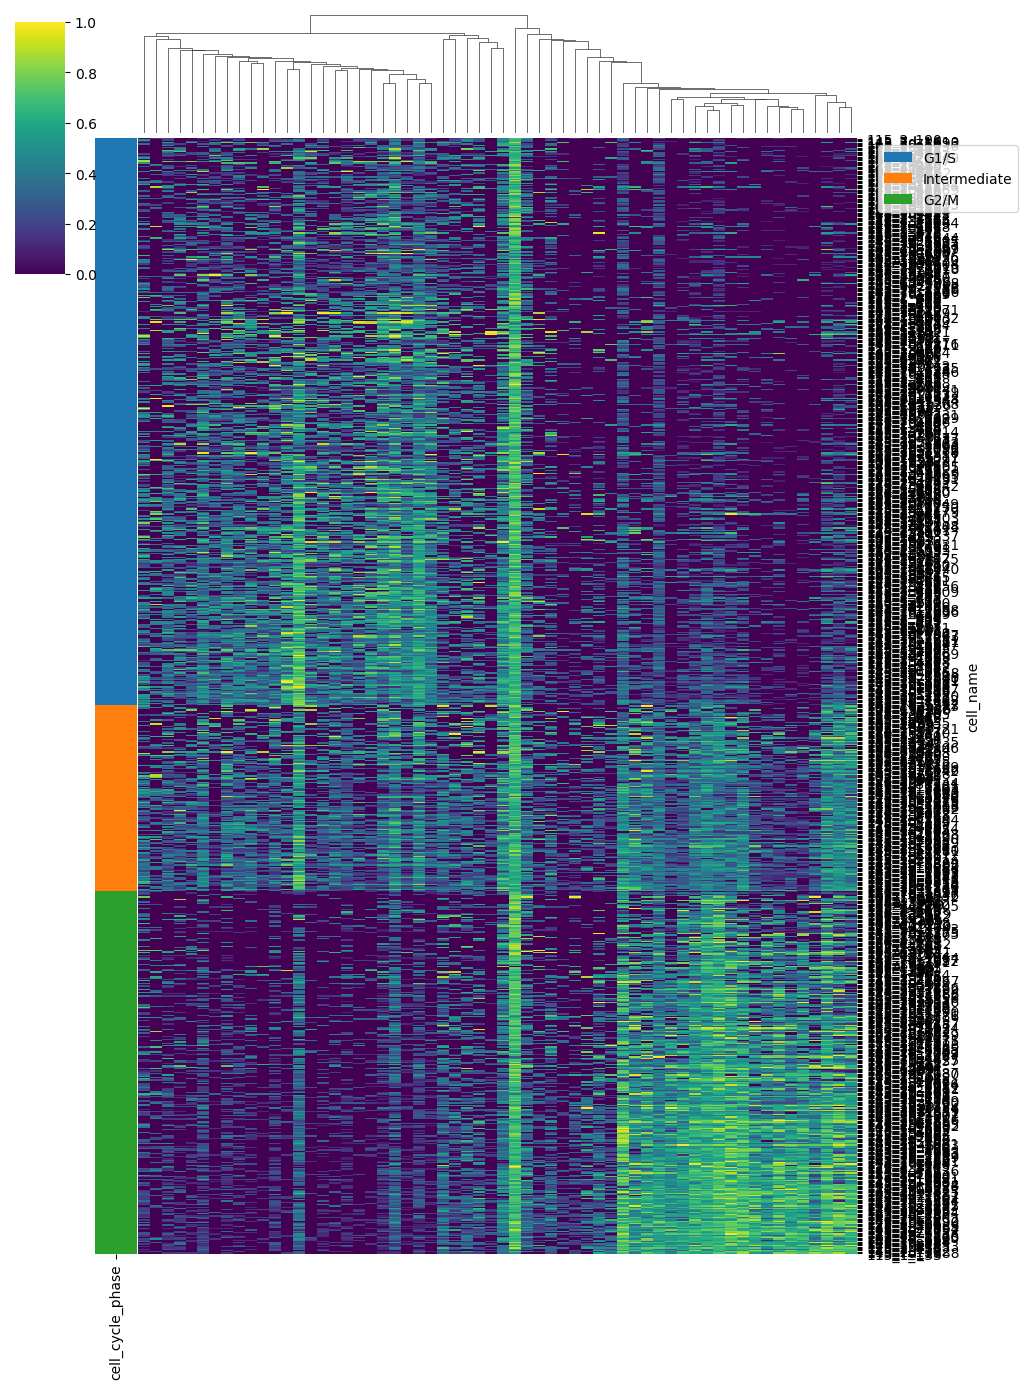

In [111]:
# Create mapping: cell-phase --> color

# Check what phases you actually have
print("Unique phases:", phases_sorted.unique())
print("Phase counts:", phases_sorted.value_counts())

# Create color mapping - make sure these match your actual phase names
phase_color_map = {
    'G1/S': '#1f77b4',
    'Intermediate': '#ff7f0e', 
    'G2/M': '#2ca02c',
}

phase_colors = phases_sorted.map(phase_color_map)


#########

# get the most iffrtuallye xpressed gens ofr wach group:
N=20
genes_list = []
for i, g in wilcoxon_positive_genes_df.sort_values(by="scores").groupby("group"):
    print(i)
    #display(g)
    genes_list = genes_list + g.names[:N].to_list()

genes_list


########


# Create the clustermap
g = sns.clustermap(
    df_sorted.loc[:, df_sorted.columns.isin(genes_list)],  # cells are row
    figsize=(10, 14),
    cmap="viridis",

    col_cluster=True, #wnat to cluster genes
    row_cluster=False,

    method="average", # method to do clustering
    metric="correlation", # metric to aggregate in hierarhcical clustering

    row_colors=phase_colors,
    xticklabels=False,
    yticklabels=True,
    colors_ratio=0.05,  
    dendrogram_ratio=0.1,

    standard_scale=1, #for each row(0) or column, subtract the minimum and divide each by its maximum.

)

# Add legend
from matplotlib.patches import Patch
legend_elements = [Patch(facecolor=color, label=phase) 
                   for phase, color in phase_color_map.items()]
g.ax_heatmap.legend(handles=legend_elements, loc='upper left', 
                    bbox_to_anchor=(1.02, 1), frameon=True)

# Final Decision

<Axes: xlabel='n_positive'>

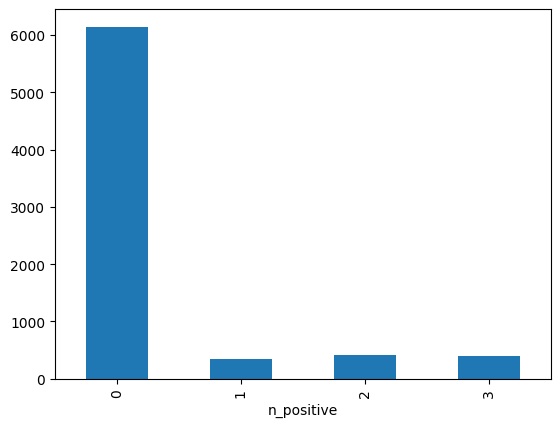

In [113]:
# add if it was èsotve before
positive_genes_df["p_by_broad"] = [g in positive_genes_df[positive_genes_df.label == "positive"].gene.to_list() for g in positive_genes_df.gene.to_list()]

# count
positive_genes_df["n_positive"] = positive_genes_df.apply(
    lambda x: x[["p_by_broad", "p_by_std", "p_by_wilcoxon"]].sum(),
    axis=1
)

# sort
positive_genes_df = positive_genes_df.sort_values(by="n_positive", ascending=False)

positive_genes_df.n_positive.value_counts().sort_index().plot(kind="bar")

In [116]:
# asing label
THR=3
positive_genes_df["definitive_positive"] = [True if g in positive_genes_df[positive_genes_df["n_positive"] >= THR].gene.to_list() else False for g in positive_genes_df.gene]

# see inly rwl ptiise
definitive_df = positive_genes_df[positive_genes_df["definitive_positive"] == True].sort_values(by="gene")
display(definitive_df)

print(definitive_df.gene.to_list())


gene  geneset_count  is_guaranteed     label  geneset_percent  \
74    ANAPC11             39          False  positive        13.402062   
77    ANAPC15             38          False  positive        13.058419   
488   ANAPC16             16          False  positive         5.498282   
75     ANAPC5             39          False  positive        13.402062   
965    ANKLE2              9          False  positive         3.092784   
...       ...            ...            ...       ...              ...   
960     YWHAH             10          False  positive         3.436426   
487   ZFP36L1             17          False  positive         5.841924   
1147   ZNHIT1              8          False  positive         2.749141   
123    ZWILCH             32          False  positive        10.996564   
34      ZWINT             48           True  positive        16.494845   

      p_by_std  p_by_wilcoxon  p_by_broad  n_positive  definitive_positive  
74        True           True        True           3                 True  
77        True           True        True           3                 True  
488       True           True        True           3                 True  
75        True           True        True           3                 True  
965       True           True        True           3                 True  
...        ...            ...         ...         ...                  ...  
960       True           True        True           3                 True  
487       True           True        True           3                 True  
1147      True           True        True           3                 True  
123       True           True        True           3                 True  
34        True           True        True           3                 True  

[392 rows x 10 columns]

['ANAPC11', 'ANAPC15', 'ANAPC16', 'ANAPC5', 'ANKLE2', 'ANKRD17', 'ANP32E', 'ARF6', 'ARHGEF39', 'ARL6IP1', 'ASPM', 'ATAD2', 'ATAD5', 'AURKA', 'AURKB', 'BABAM1', 'BAZ1B', 'BCL7A', 'BCL7B', 'BCL7C', 'BID', 'BIRC5', 'BORA', 'BRCA1', 'BRCA2', 'BRD7', 'BRD8', 'BTG3', 'BUB1', 'BUB1B', 'BUB3', 'CALM1', 'CALM2', 'CALM3', 'CCNA2', 'CCNB1', 'CCNB2', 'CCND2', 'CCND3', 'CCNE1', 'CCNE2', 'CCNF', 'CCNG1', 'CCNG2', 'CCNH', 'CCSAP', 'CDC20', 'CDC25A', 'CDC25B', 'CDC25C', 'CDC27', 'CDC45', 'CDC5L', 'CDC6', 'CDCA2', 'CDCA3', 'CDCA5', 'CDCA7', 'CDCA8', 'CDK1', 'CDK16', 'CDK2', 'CDK2AP2', 'CDK4', 'CDK5RAP2', 'CDK6', 'CDKN1A', 'CDKN1B', 'CDKN2A', 'CDKN2C', 'CDKN2D', 'CDKN3', 'CDT1', 'CENPA', 'CENPE', 'CENPF', 'CENPH', 'CENPJ', 'CENPK', 'CENPL', 'CENPM', 'CENPN', 'CENPO', 'CENPQ', 'CENPU', 'CENPV', 'CENPW', 'CEP135', 'CEP152', 'CEP55', 'CEP70', 'CEP78', 'CFLAR', 'CHAF1A', 'CHAF1B', 'CHEK1', 'CHEK2', 'CHMP4B', 'CIT', 'CKAP2', 'CKAP2L', 'CKAP5', 'CKS1B', 'CKS2', 'CLSPN', 'CNTRL', 'CRY1', 'CSNK1E', 'CTCF', 'CTD

# Save

In [120]:
positive_genes_df.to_csv(config["data_paths"]["final_positive_genes"], index=False)

# Caveats

1) missing genes in scrna daatset ase not studied
2) removed geens with  expresson
3) some genes are expressed in mutple pahses (ex CDK1)
4) cell type expression differces are not accounted
5) using std, we have to average bvefpre. bit mean is not a good metric for spiky expression
6) stat tets not ptimal for scrna data

 ---
# Optional
 ---

# Compare to non cyclins cells

These postive gens shoudl be much more expressed

In [129]:
# adata of only cycling cells
# 1. Get the indices (cell names) of the top 200 scores
top_200_indices = adata.obs["cc_score"].nlargest(200).index
# 2. Get the indices (cell names) of the bottom 200 scores
bottom_200_indices = adata.obs["cc_score"].nsmallest(200).index
selected_indices = top_200_indices.tolist() + bottom_200_indices.tolist()

adata_binary = adata[selected_indices, definitive_df.gene.to_list()].copy()

# Create a new column in adata_binary.obs to label the groups
group_labels = []
for cell in adata_binary.obs_names:
    if cell in top_200_indices:
        group_labels.append("Top_200_Score")
    elif cell in bottom_200_indices:
        group_labels.append("Bottom_200_Score")

adata_binary.obs["cc_group"] = pd.Categorical(group_labels)

# Sort the observation metadata by cc_score
adata_binary.obs.sort_values(by='cc_score', ascending=True, inplace=True)
# Reindex the AnnData object based on the sorted order of .obs
adata_binary = adata_binary[adata_binary.obs_names, :].copy()

adata_binary

AnnData object with n_obs × n_vars = 400 × 392
    obs: 'sample', 'cell_type', 'complexity', 'umap1', 'umap2', 'g1s_score', 'g2m_score', 'cell_cycle_phase', 'mp_top_score', 'mp_top', 'mp_assignment', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'G2_M_score', 'G1_S_score', 'cc_score', 'cc_group'
    var: 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells'
    uns: 'log1p', 'cell_type_colors', 'sample_colors', 'cell_cycle_phase_colors'
    obsm: 'umap'

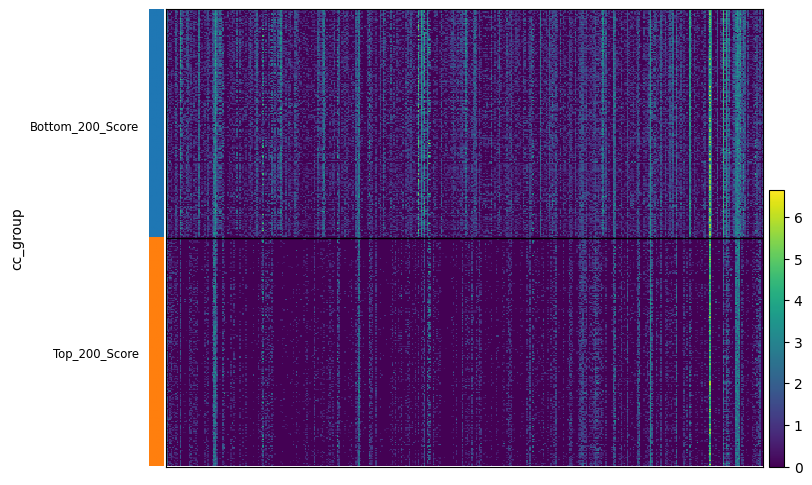

In [130]:
sc.pl.heatmap(
    adata_binary,
    var_names = adata_binary.var_names,
    groupby="cc_group",
    #log=True,
    #standard_scale="obs"
    #swap_axes=True,
    #show_gene_labels=True
    dendrogram=False
)

# Are there Enriched genesets?

After getting definitive positive genes, perform hypergeometric test.

Universe is ALL genesets (not jsut the one found previusly) with AT LEAST 10 genes.

In [122]:
# plit psoive genes
positive_genes = set(positive_genes_df[positive_genes_df.definitive_positive == True].gene)
print("Number positive genes", len(positive_genes))

# Read MSigDB genesets
df_genesets = dataf.load_json_folder_to_df(config["data_paths"]["MSigDB_all_data"])
df_genesets = df_genesets.drop_duplicates(subset=['set_name'], keep='first')
# rename
df_genesets["gene_list"] = df_genesets["geneSymbols"]
# Recalculate n_genes
df_genesets["n_genes"] = df_genesets["gene_list"].apply(len)
#subset
df_genesets = df_genesets[["set_name", "gene_list", "n_genes"]]

#  extartc only psotive geens per geneset
df_genesets["genes_positive"] = df_genesets.apply(
    lambda row: (
        [g for g in row["gene_list"] if g in positive_genes]
    ),
    axis=1
)
df_genesets["n_genes_positive"] = df_genesets["genes_positive"].apply(len)
df_genesets.sort_values(by="n_genes_positive", ascending=False, inplace=True)

display(df_genesets.head(5))

############

# read psortive genesets found before
df_genesets_positive = pd.read_csv(config["data_paths"]["positive_genesets"])
df_genesets_positive["gene_list"] = df_genesets_positive["geneSymbols"].apply(ast.literal_eval)
df_genesets_positive = df_genesets_positive[["set_name", "gene_list", "n_genes"]]
df_genesets_positive["genes_positive"] = df_genesets_positive.apply(
lambda row: (
        [g for g in row["gene_list"] if g in positive_genes]
    ),
    axis=1
)
df_genesets_positive["n_genes_positive"] = df_genesets_positive["genes_positive"].apply(len)
df_genesets_positive.sort_values(by="n_genes_positive", ascending=False, inplace=True)
# ratio of psotve genes
df_genesets_positive["n_genes_ratio"] = df_genesets_positive["n_genes_positive"] / df_genesets_positive["n_genes"]

display(df_genesets_positive.head(5))


Number positive genes 392


set_name  \
19134                            GOBP_CELL_CYCLE   
20256                    GOBP_CELL_CYCLE_PROCESS   
33730                      FISCHER_DREAM_TARGETS   
57722  HE_LIM_SUN_FETAL_LUNG_C5_LARGE_PRE_B_CELL   
18135                    GOBP_MITOTIC_CELL_CYCLE   

                                               gene_list  n_genes  \
19134  [AAAS, AATF, ABCB1, ABL1, ABRAXAS1, ABRAXAS2, ...     1705   
20256  [AAAS, ABCB1, ABRAXAS1, ABRAXAS2, ACTB, ACTL6A...     1348   
33730  [AAAS, AARS1, ABCB10, ABCE1, ABHD10, ABHD2, AC...      969   
57722  [AAAS, AAGAB, AAMDC, AARS1, ABCD3, ABHD12, ABH...     1363   
18135  [AAAS, AATF, ABCB1, ABL1, ABRAXAS1, ABRAXAS2, ...      931   

                                          genes_positive  n_genes_positive  
19134  [ANAPC11, ANAPC15, ANAPC16, ANAPC5, ANKLE2, AN...               305  
20256  [ANAPC11, ANAPC15, ANAPC5, ANKLE2, ANKRD17, AR...               287  
33730  [ANKRD17, ANP32E, ARHGEF39, ARL6IP1, ASPM, ATA...               259  
57722  [ANAPC15, ANP32E, ARHGEF39, ARL6IP1, ASPM, ATA...               244  
18135  [ANAPC11, ANAPC15, ANAPC16, ANAPC5, ANKLE2, AN...               241

set_name  \
49                            GOBP_CELL_CYCLE   
66                    GOBP_CELL_CYCLE_PROCESS   
44                    GOBP_MITOTIC_CELL_CYCLE   
290   HE_LIM_SUN_FETAL_LUNG_C4_CYCLING_T_CELL   
287  HE_LIM_SUN_FETAL_LUNG_C2_CYCLING_DC_CELL   

                                             gene_list  n_genes  \
49   [AAAS, AATF, ABCB1, ABL1, ABRAXAS1, ABRAXAS2, ...     1705   
66   [AAAS, ABCB1, ABRAXAS1, ABRAXAS2, ACTB, ACTL6A...     1348   
44   [AAAS, AATF, ABCB1, ABL1, ABRAXAS1, ABRAXAS2, ...      931   
290  [A1BG, AAAS, AARS1, ABHD12, ABI2, ACAD9, ACAT2...      939   
287  [AAAS, AARS1, AARS2, AASDH, ABCB7, ABCB8, ACAA...     1423   

                                        genes_positive  n_genes_positive  \
49   [ANAPC11, ANAPC15, ANAPC16, ANAPC5, ANKLE2, AN...               305   
66   [ANAPC11, ANAPC15, ANAPC5, ANKLE2, ANKRD17, AR...               287   
44   [ANAPC11, ANAPC15, ANAPC16, ANAPC5, ANKLE2, AN...               241   
290  [ANAPC15, ARHGEF39, ARL6IP1, ASPM, ATAD2, ATAD...               231   
287  [ANAPC15, ARHGEF39, ASPM, ATAD2, ATAD5, AURKA,...               227   

     n_genes_ratio  
49        0.178886  
66        0.212908  
44        0.258861  
290       0.246006  
287       0.159522

/tmp/ipykernel_12072/1603268317.py:33: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


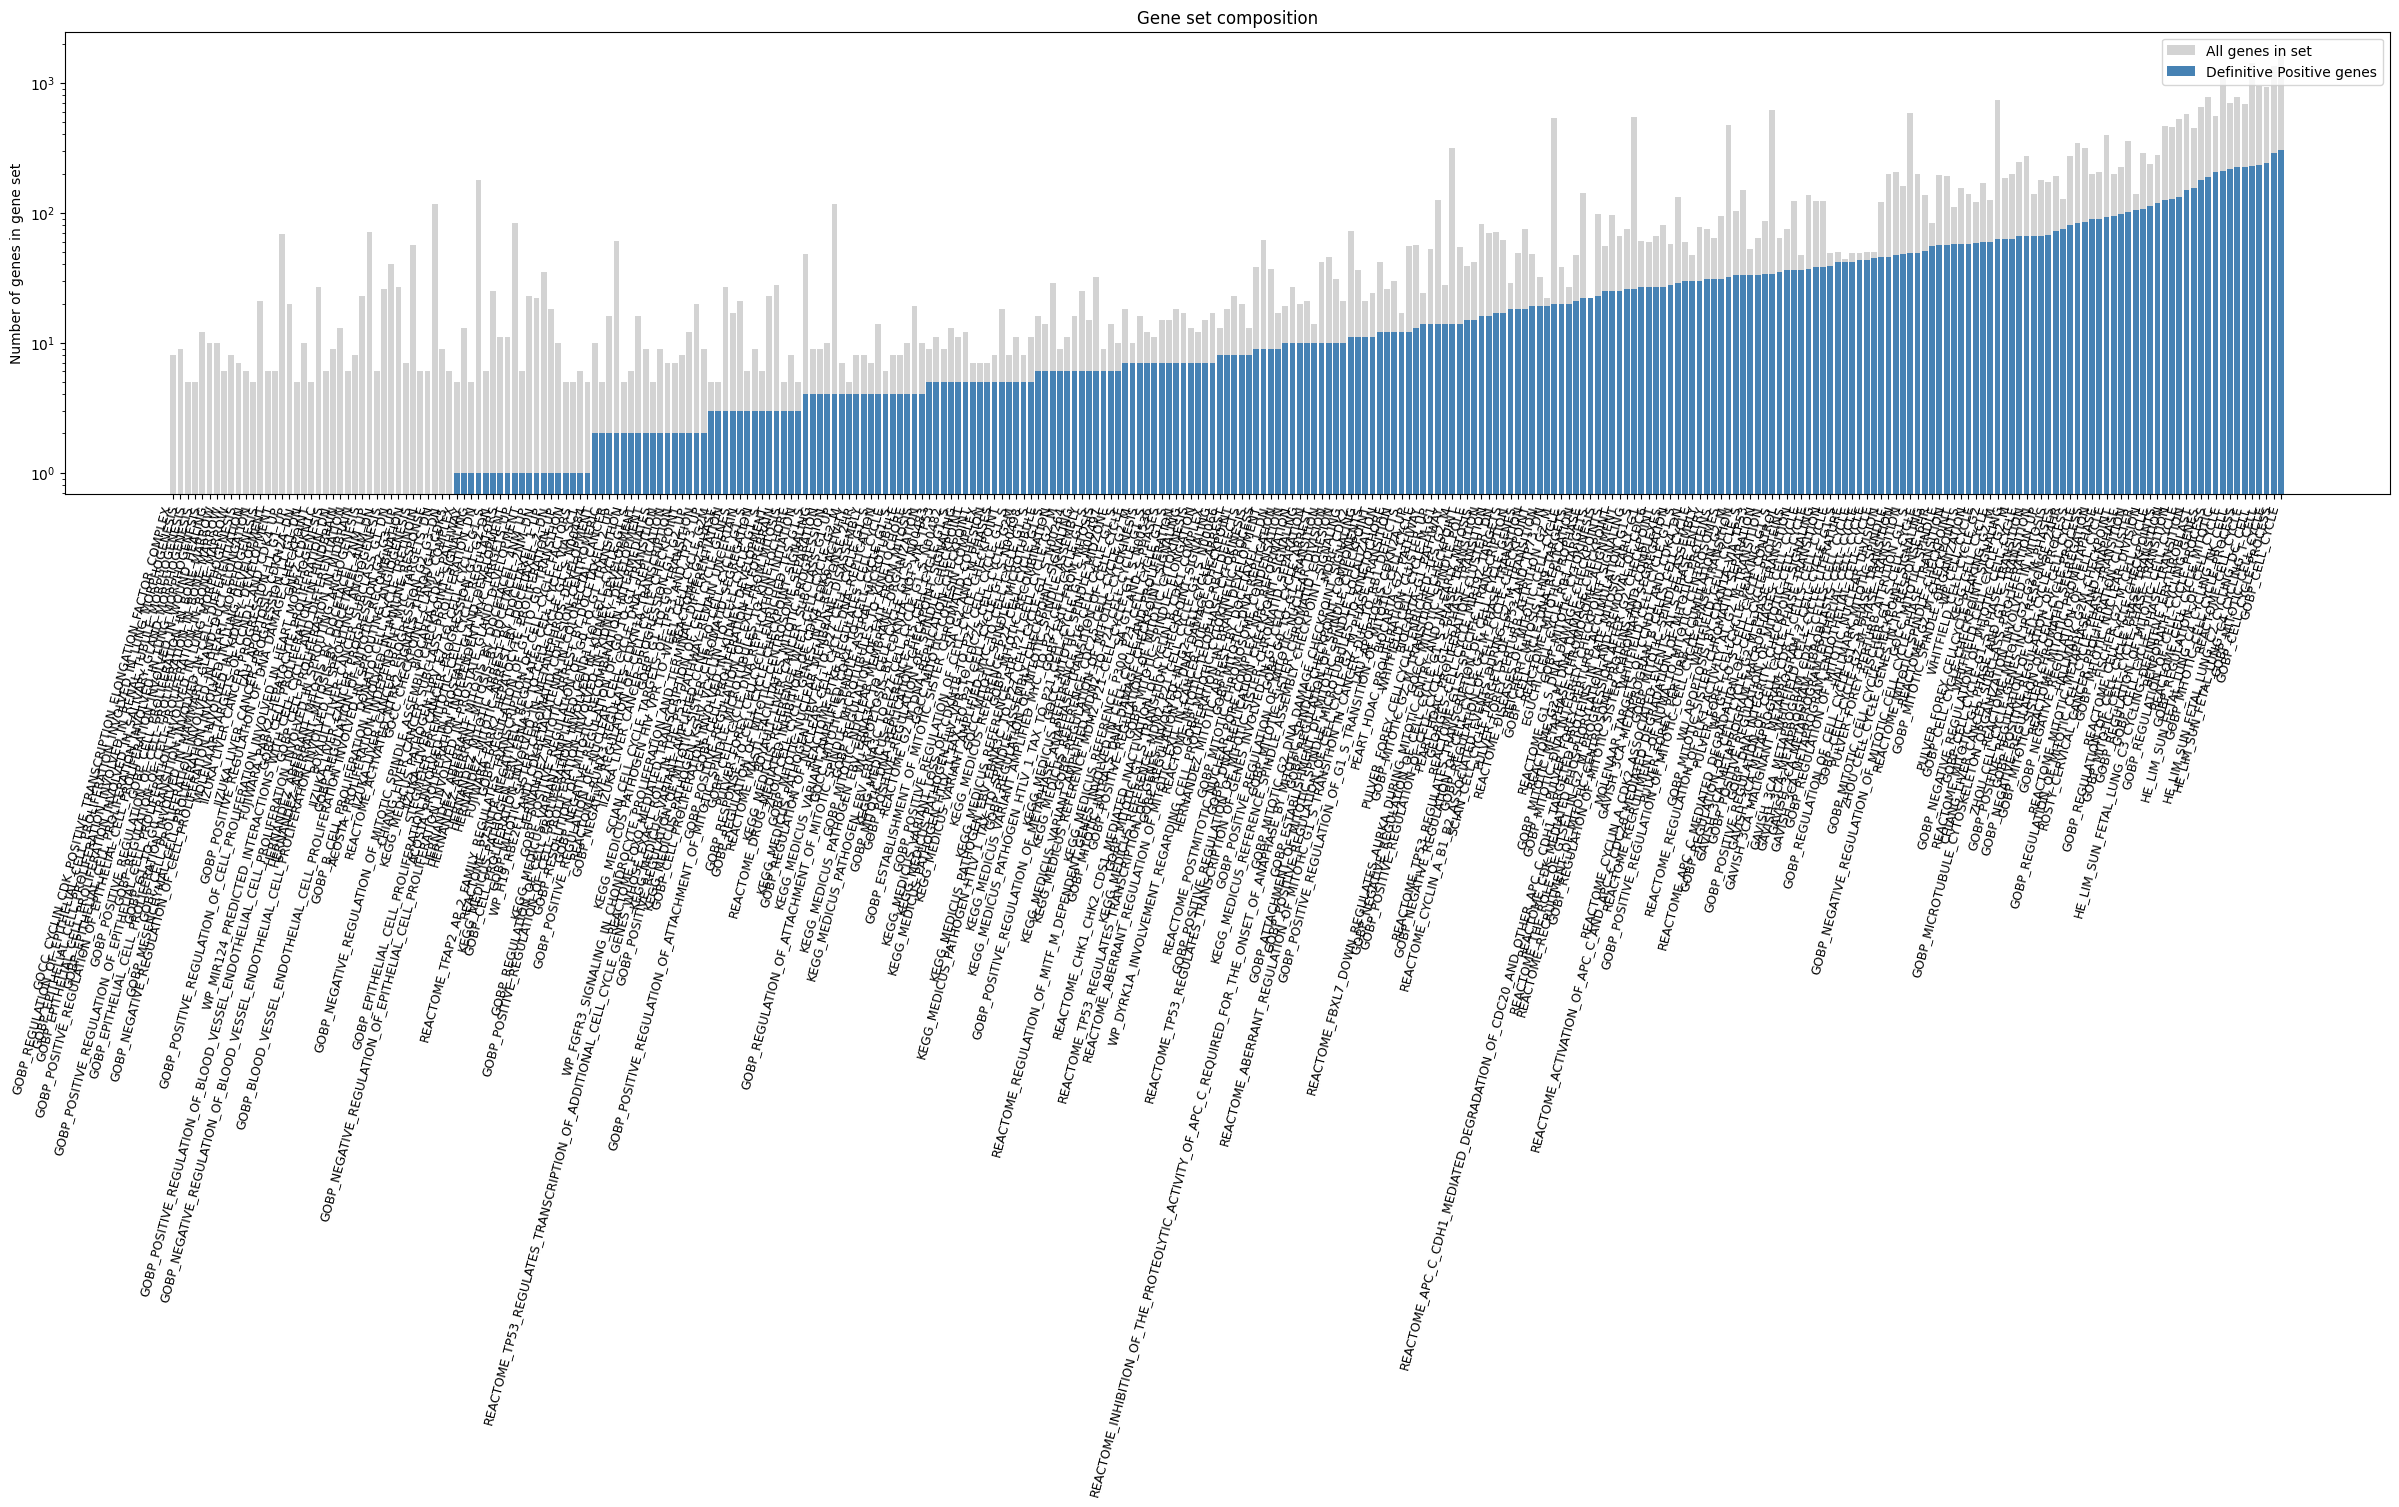

In [123]:
# HOW MANY DEFINITIVE POSITIVE GENES IN ORIGINAL POSITIVE GENESTES

# Sort by significance (optional)
df_plot = df_genesets_positive.copy().sort_values("n_genes_positive")

# Create figure and axis
fig, ax = plt.subplots(figsize=(30, 6))

# Base layer: total genes
ax.bar(
    df_plot["set_name"],
    df_plot["n_genes"],
    color="lightgray",
    label="All genes in set",
)

# Overlay: positive genes
ax.bar(
    df_plot["set_name"],
    df_plot["n_genes_positive"],
    color="steelblue",
    label="Definitive Positive genes"
)

# Add labels and aesthetics
ax.set_xticks(range(len(df_plot["set_name"])))
ax.set_xticklabels(df_plot["set_name"], rotation=75, ha="right", fontsize=9)
ax.set_ylabel("Number of genes in gene set")
ax.set_title("Gene set composition")
ax.legend(loc="upper right")
ax.set_yscale("log")

plt.tight_layout()
plt.show()


In [127]:
# HYPERGEMOETRIC TEST

# Filter genesets with enough genes
    # ATTENTION
    # CANNOT USE TOO SMALL DRAWING (n) --> test power comes from the changing probabilities over several draws, known as sampling without replacemen
df_genesets_big = df_genesets[df_genesets.n_genes >= 1].copy()

# Define background
total_genes = len(set().union(*df_genesets_big["gene_list"]))
total_positive = len(set().union(*df_genesets_big["genes_positive"]))
print(f"Unique total genes: {total_genes}")
print(f"Unique total positive genes: {total_positive}")

# Run enrichment test
results = df_genesets_big.apply(
    lambda row: pd.Series(
        dataf.per_cluster_hypergeom_test(
            row["n_genes"], 
            row["n_genes_positive"], 
            total_genes, 
            total_positive
        )
    ), 
    axis=1
)
results.columns = ["enrichment_prob", "enrichment_pvalue"]

# Combine results
df_genesets_enriched = pd.concat([df_genesets_big, results], axis=1)
df_genesets_enriched = df_genesets_enriched.sort_values("enrichment_pvalue")

# Multiple testing correction (FDR)
df_genesets_enriched["enrichment_pvalue_adj"] = multipletests(
    df_genesets_enriched["enrichment_pvalue"], 
    method="fdr_bh"
)[1]
df_genesets_enriched["significant"] = df_genesets_enriched["enrichment_pvalue_adj"] < 0.05

# Summary
print(f"\nSignificant enriched gene sets: {df_genesets_enriched['significant'].sum()} / {len(df_genesets_enriched)}")
display(
    df_genesets_enriched[
        ["set_name", "n_genes", "n_genes_positive", 
         "enrichment_prob", "enrichment_pvalue", 
         "enrichment_pvalue_adj", "significant"]
    ].head(10)
)

# only enriched
df_genesets_significant = df_genesets_enriched[df_genesets_enriched['significant'] == True]

Unique total genes: 43351
Unique total positive genes: 388

Significant enriched gene sets: 7994 / 35134


set_name  n_genes  \
39663             FIGAROL_EGFR_TKI_DRUG_TOLERANT_CELL_DN      495   
23424                  GOBP_MEIOSIS_I_CELL_CYCLE_PROCESS      142   
8470   GOCC_TRANSFERASE_COMPLEX_TRANSFERRING_PHOSPHOR...      310   
35041                       REACTOME_CELLULAR_SENESCENCE      197   
3778          GSE34205_HEALTHY_VS_RSV_INF_INFANT_PBMC_DN      200   
49753                                           MORF_DEK      264   
37981              MOLENAAR_TARGETS_OF_CCND1_AND_CDK4_DN       59   
4443                  GSE2128_C57BL6_VS_NOD_THYMOCYTE_UP      199   
5475   GSE16451_CTRL_VS_WEST_EQUINE_ENC_VIRUS_IMMATUR...      200   
38615                                    PID_E2F_PATHWAY       73   

       n_genes_positive  enrichment_prob  enrichment_pvalue  \
39663               198    2.578402e-290                0.0   
23424                30     2.327813e-32                0.0   
8470                 30     5.428911e-22                0.0   
35041                30     7.180237e-28                0.0   
3778                 30     1.143374e-27                0.0   
49753                30     4.950161e-24                0.0   
37981                30     5.331897e-46                0.0   
4443                 30     9.799980e-28                0.0   
5475                 30     1.143374e-27                0.0   
38615                30     2.239099e-42                0.0   

       enrichment_pvalue_adj  significant  
39663                    0.0         True  
23424                    0.0         True  
8470                     0.0         True  
35041                    0.0         True  
3778                     0.0         True  
49753                    0.0         True  
37981                    0.0         True  
4443                     0.0         True  
5475                     0.0         True  
38615                    0.0         True

Original gene sets: 291
Significantly enriched gene sets: 7994
Overlap (shared sets): 230

Original genesets that are enriched:


set_name  \
49                                     GOBP_CELL_CYCLE   
66                             GOBP_CELL_CYCLE_PROCESS   
44                             GOBP_MITOTIC_CELL_CYCLE   
290            HE_LIM_SUN_FETAL_LUNG_C4_CYCLING_T_CELL   
287           HE_LIM_SUN_FETAL_LUNG_C2_CYCLING_DC_CELL   
..                                                 ...   
169       SCIAN_CELL_CYCLE_TARGETS_OF_TP53_AND_TP73_UP   
114  GOBP_CELL_PROLIFERATION_INVOLVED_IN_METANEPHRO...   
21   KEGG_MEDICUS_VARIANT_AMPLIFIED_CCND1_TO_CELL_C...   
112  GOBP_MITOTIC_SISTER_CHROMATID_COHESION_CENTROM...   
125  GOBP_REGULATION_OF_CELL_PROLIFERATION_INVOLVED...   

                                             gene_list  n_genes  \
49   [AAAS, AATF, ABCB1, ABL1, ABRAXAS1, ABRAXAS2, ...     1705   
66   [AAAS, ABCB1, ABRAXAS1, ABRAXAS2, ACTB, ACTL6A...     1348   
44   [AAAS, AATF, ABCB1, ABL1, ABRAXAS1, ABRAXAS2, ...      931   
290  [A1BG, AAAS, AARS1, ABHD12, ABI2, ACAD9, ACAT2...      939   
287  [AAAS, AARS1, AARS2, AASDH, ABCB7, ABCB8, ACAA...     1423   
..                                                 ...      ...   
169  [CDKN1A, GAS2L1, HRAS, JAG2, LTBP2, NEDD9, SEP...        9   
114  [BMP7, EGR1, GPC3, MYC, OSR1, PDGFRB, PTCH1, S...       10   
21                [CCND1, CDK4, E2F1, E2F2, E2F3, RB1]        6   
112                   [BOD1, BUB1, NAA10, NAA50, SGO1]        5   
125  [BMP4, BMP7, CFLAR, EGR1, FLCN, GATA3, IL6R, I...       16   

                                        genes_positive  n_genes_positive  \
49   [ANAPC11, ANAPC15, ANAPC16, ANAPC5, ANKLE2, AN...               305   
66   [ANAPC11, ANAPC15, ANAPC5, ANKLE2, ANKRD17, AR...               287   
44   [ANAPC11, ANAPC15, ANAPC16, ANAPC5, ANKLE2, AN...               241   
290  [ANAPC15, ARHGEF39, ARL6IP1, ASPM, ATAD2, ATAD...               231   
287  [ANAPC15, ARHGEF39, ASPM, ATAD2, ATAD5, AURKA,...               227   
..                                                 ...               ...   
169                                     [CDKN1A, TP53]                 2   
114                                      [EGR1, STAT1]                 2   
21                                        [CDK4, E2F1]                 2   
112                                      [BUB1, NAA10]                 2   
125                                      [CFLAR, EGR1]                 2   

     n_genes_ratio  
49        0.178886  
66        0.212908  
44        0.258861  
290       0.246006  
287       0.159522  
..             ...  
169       0.222222  
114       0.200000  
21        0.333333  
112       0.400000  
125       0.125000  

[230 rows x 6 columns]


Original genesets that are NOT enriched:


set_name  \
246      CHIANG_LIVER_CANCER_SUBCLASS_PROLIFERATION_DN   
176                BOYAULT_LIVER_CANCER_SUBCLASS_G1_UP   
255    ACOSTA_PROLIFERATION_INDEPENDENT_MYC_TARGETS_DN   
231    ACOSTA_PROLIFERATION_INDEPENDENT_MYC_TARGETS_UP   
165     HERNANDEZ_ABERRANT_MITOSIS_BY_DOCETACEL_2NM_UP   
..                                                 ...   
122  GOBP_NEGATIVE_REGULATION_OF_MITOTIC_SPINDLE_AS...   
26   KEGG_MEDICUS_PATHOGEN_EBV_EBNA3C_TO_CELL_CYCLE...   
2                        GOCC_CHECKPOINT_CLAMP_COMPLEX   
98   GOBP_EPITHELIAL_CELL_PROLIFERATION_INVOLVED_IN...   
97   GOBP_EPITHELIAL_CELL_PROLIFERATION_INVOLVED_IN...   

                                             gene_list  n_genes  \
246  [AADAC, AASS, ABAT, ABCA6, ABCA8, ABCB11, ABCB...      179   
176  [ABCC10, ABHD3, ADAR, ADGRG1, AHNAK, AHSA2P, A...      116   
255  [ACRV1, ACSM3, ADAM8, ADAMTSL4, ADGRE5, ADGRG1...      116   
231  [AATF, BLMH, CCNE1, CD320, CLUH, CRYBG2, CSE1L...       84   
165  [AGT, ARHGDIB, ASNS, BNC2, BTRC, CASP7, CD3D, ...       71   
..                                                 ...      ...   
122              [MAD1L1, MAD2L1BP, PRAP1, SKA1, SKA3]        5   
26                       [E2F1, E2F2, E2F3, RB1, SKP2]        5   
2                    [HUS1, HUS1B, RAD1, RAD9A, RAD9B]        5   
98                   [AREG, ESR1, MED1, TFAP2C, WNT5A]        5   
97                    [FGF10, FGFR2, NKX3-1, SHH, TNF]        5   

                genes_positive  n_genes_positive  n_genes_ratio  
246                     [RHOB]                 1       0.005587  
176  [DNAJC9, LBR, LMNA, RPA1]                 4       0.034483  
255                         []                 0       0.000000  
231                    [CCNE1]                 1       0.011905  
165                         []                 0       0.000000  
..                         ...               ...            ...  
122                     [SKA1]                 1       0.200000  
26                      [E2F1]                 1       0.200000  
2                      [RAD9A]                 1       0.200000  
98                          []                 0       0.000000  
97                          []                 0       0.000000  

[61 rows x 6 columns]

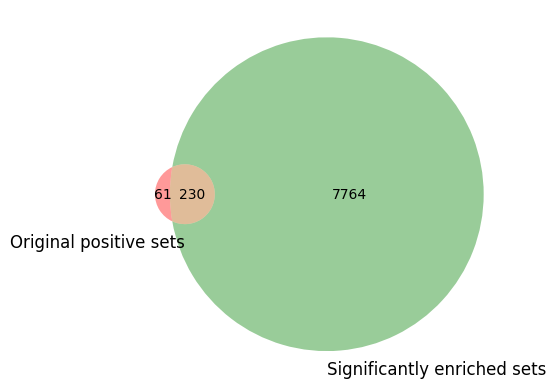

In [128]:
# PLOT HOW MANY ORTIGNA PSTIVE GENESTES ARE ENRICHED BASED ON DEFINITVE POSTIVE GENS

# Define your sets
original_genesets = set(df_genesets_positive.set_name)
enriched_genesets = set(df_genesets_significant.set_name)
intersection_genesets = original_genesets & enriched_genesets
only_original_genesets = original_genesets - enriched_genesets
only_enriched_genesets = enriched_genesets - original_genesets

#  summary info
print(f"Original gene sets: {len(original_genesets)}")
print(f"Significantly enriched gene sets: {len(enriched_genesets)}")
print(f"Overlap (shared sets): {len(intersection_genesets)}")

print("\nOriginal genesets that are enriched:")
display(df_genesets_positive[df_genesets_positive.set_name.isin(intersection_genesets)])

print("\nOriginal genesets that are NOT enriched:")
display(df_genesets_positive[df_genesets_positive.set_name.isin(only_original_genesets)]
        .sort_values(by="n_genes", ascending=False))

# --- Visualization ---
venn2(
    subsets=(
        len(only_original_genesets),
        len(only_enriched_genesets),
        len(intersection_genesets)
    ),
    set_labels=('Original positive sets', 'Significantly enriched sets'),
)
